#### Week 2: Building Advanced RAG Applications.  Authored by Chris Sanchez.

# Week 2 - Notebook 5

# Overview

Welcome to Notebook 5, we can see the light at the end of the tunnel in our RAG dataflow ☀️...we are at the final step before displaying our results to the end user in a Streamlit UI.  In this notebook we'll cover setting up a connection with our LLM of choice through the `litellm` package and round it out with an initial baseline evaluation of our entire system.  

#### Week Two
* ~Part 4~:
  * ~Add Hybrid Search and ReRanker to the mix (new benchmark)~
* **Part 5 (THIS NOTEBOOK)**:
  * **LLM Integration & Evaluation**

![arch_diagram]( 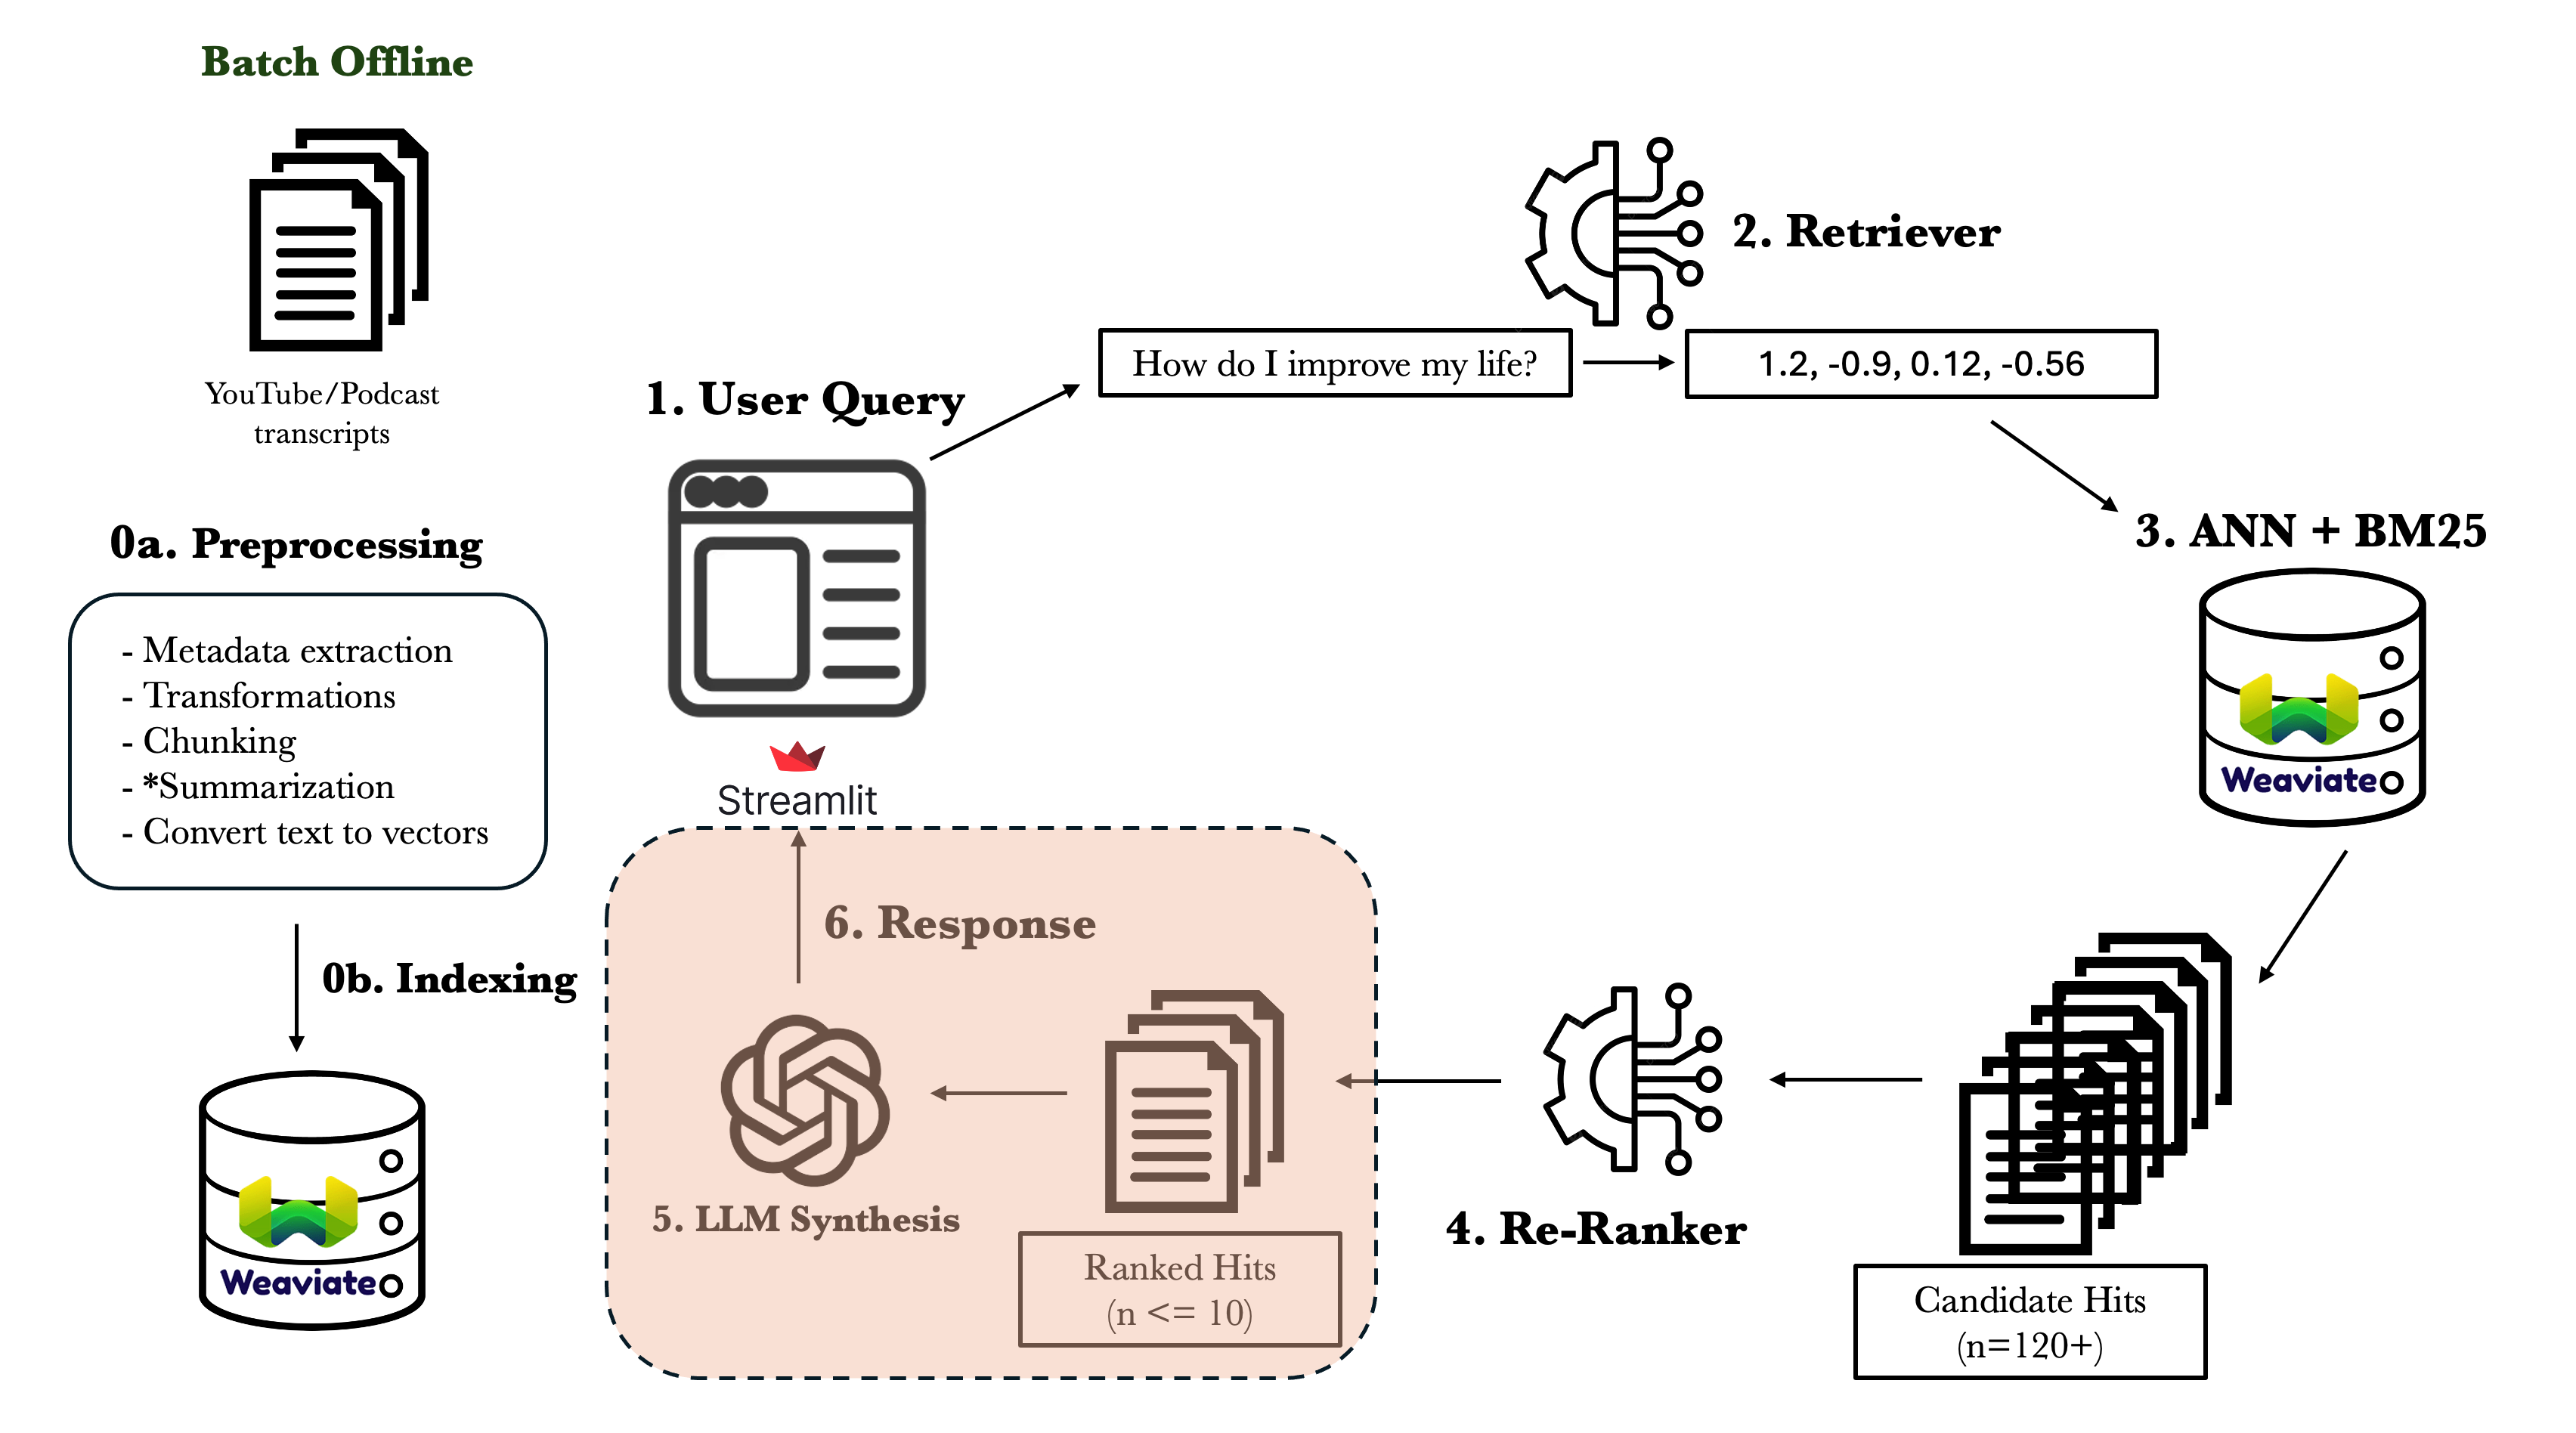)

### Notebook Highlights
In this notebook we'll cover the following topics:
1. Crafting our RAG system message
2. Crafting our RAG user message
3. Making chat completions using the `litellm` framework
4. Build a `Callable` RAG pipeline
5. Introduction to the `deepeval` LLM evaluation framework
6. Get a baseline score for our LLM responses

💥 Let's get STARTED! 💥

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

from dotenv import load_dotenv, find_dotenv
envs = load_dotenv(find_dotenv(), override=True)

from warnings import filterwarnings
filterwarnings('ignore')

from src.database.database_utils import get_weaviate_client
from src.database.weaviate_interface_v4 import WeaviateWCS
from src.llm.llm_interface import LLM
from src.llm.llm_utils import get_token_count
from src.llm.prompt_templates import (huberman_system_message,
                                      question_answering_prompt_series,
                                      generate_prompt_series)
from src.preprocessor.preprocessing import FileIO
from src.reranker import ReRanker
from litellm import ModelResponse

from typing import Literal
from rich import print
import os

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/pydantic/_internal/_config.py:284: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)
/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/litellm/proxy/_types.py:167: PydanticDeprecatedSince20: Pydantic V1 style `@root_validator` validators are deprecated. You should migrate to Pydantic V2 style `@model_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  @root_validator(pre=True)
/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/litellm/proxy/_types.py:254: PydanticDeprecatedSince20: `pydantic.con

### Set Constants

In [2]:
retriever = get_weaviate_client()
reranker = ReRanker()
collections = retriever.show_all_collections()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
#define collection_name
print(collections)
collection_name = 'Huberman_minilm_256'

['Huberman_gte_large_1024', 'Huberman_minilm_256']

In [7]:
#use question bank from previous notebook
queries = ['How to fight age-related muscle loss',
           'How can listeners support the Huberman Lab podcast',
           'What is the role of the mid-singulate cortex in the human brain',
           'Why is sleep so important to maximizing healthspan']

#### Gather initial reranked responses for our queries.  We'll use these later in the notebook

In [8]:
%%time
#1st-Stage Retrieval: Deep search over 200 documents
responses = [retriever.hybrid_search(q, collection_name, alpha=0.25, limit=200) for q in queries]

#2nd-Stage Reranking: keeping only top-3 results
reranked = [reranker.rerank(resp, queries[i], top_k=3) for i,resp in enumerate(responses)]

len(responses) == len(reranked)

CPU times: user 10.6 s, sys: 1.68 s, total: 12.2 s
Wall time: 18.1 s


True

## Discussion
***

Alright, the stage is now set, we have obtained our reranked results and now we are ready to feed them into our LLM for synthesis.  We've completed the **Retrieval** part of RAG, now it's time to Augment the Generation of an answer using those results...but how exactly?

As we've already discussed, effective RAG depends heavily on the quality of retrieved material.  Hopefully, by now as you've worked through Notebooks 3 and 4, you feel confident that you've built a top-notch system, one that can deliver the best possible results given the corpus you have to work with.  What's left to do now, is feed those results into the LLM as context so the model can perform its job of answer synthesis, this task is primarily accomplished through **prompt engineering**.  

*** *Side note: I try to stay consistent by using the word "message" for describing LLM input, however, throughout this notebook/course I will refer to both "messages" and "prompts" synonymously.* 

### System Message
***
The system message serves as a directive to the model, providing guidance on how to interpret and respond to subsequent user inputs. If crafted well, the system message not only sets the tone for the interaction but also influences the nature and quality of the model's responses. Therefore, it's essential to ensure that the system message is explicit, detailed, and comprehensive. By providing clear instructions and context, end users can more readily expect that the model will produce the desired outcomes. If you look at the [`src/llm/prompt_templates.py`](https://github.com/americanthinker/vectorsearch-applications/blob/main/src/llm/prompt_templates.py) file, you'll see a series of pre-defined message templates for this course.  The primary `system_message` that we'll be using is the `huberman_system_message`:

```
- 1. You are a repository of knowledge and wisdom about the Huberman Lab podcast.
- 2. The Huberman Lab podcast is hosted by Dr. Andrew Huberman, a neuroscientist and tenured professor of neurobiology 
and ophthalmology at Stanford School of Medicine. The podcast discusses neuroscience and science-based tools, 
including how our brain and its connections with the organs of our body control our perceptions, our behaviors, 
and our health, as well as existing and emerging tools for measuring and changing how our nervous system works. 
The podcast is frequently ranked in the top 10 of all podcasts globally and is often ranked #1 in the categories 
of Science, Education, and Health & Fitness.
- 3. Your task is to answer questions about the Huberman Lab podcast only using the context provided in the user 
message.
- 4. Only use the context provided to answer the question. Do not use any external knowledge or resources to answer the question.
```

The **numbers you see above are not part of the actual prompt**, but I've included them here to act as a guide for this discussion:
1. We are explicitly telling the model what it's primary goal or purpose in life is.
2. We provide the model with some background information about the podcast that will be present with every API call.
3. We eplicitly tell the model what it's primary task will be (this will be repeated again in the user message).
4. Because we are building a RAG system, and presumably don't want the model to generate answers based on what it already *thinks* it knows, we are instructing the LLM to stick to the material presented (to the extent that it will listen 😼).

In [9]:
#to see the actual prompt without numbers
print(huberman_system_message)

You are a repository of knowledge and wisdom about the Huberman Lab podcast.
The Huberman Lab podcast is hosted by Dr. Andrew Huberman, a neuroscientist and tenured professor of neurobiology 
and ophthalmology at Stanford School of Medicine. The podcast discusses neuroscience and science-based tools, 
including how our brain and its connections with the organs of our body control our perceptions, our behaviors, 
and our health, as well as existing and emerging tools for measuring and changing how our nervous system works. 
The podcast is frequently ranked in the top 10 of all podcasts globally and is often ranked #1 in the categories 
of Science, Education, and Health & Fitness.
Your task is to answer questions about the Huberman Lab podcast only using the context provided in the user 
message.
Only use the context provided to answer the question. Do not use any external knowledge or resources to answer the 
question.

### User Message
***
Here's where it gets interesting...The user message (or it could be the assistant message if you'd like...) is the focal point of RAG.  It's the entrypoint for feeding our retrieved context (which we worked so hard to curate), into the LLM for consumption.  To enable this context feeding, I've created a user prompt: `question_answering_prompt_series` and a helper prompt generation function that will take a series of retrieved results and format them properly.  Let's take a look:

```
- 1. Your task is to synthesize and reason over a series of transcripts of an interview between Andrew Huberman and his 
guest(s).  After your synthesis, use the series of transcripts to answer the below question.  The series will be in the 
following format:

- 2. 
-----------------------
Show Summary: <summary>
Show Guest: <guest> 
Transcript: <transcript>
------------------------

- 3. 
Start Series:
------------------------
{series}
------------------------

- 4. 
Question:

{question}

------------------------
- 5.  Answer the question and provide reasoning if necessary to explain the answer.

    1. If the context does not provide enough information to answer the question, then
    state that you cannot answer the question with the provided context.
    2. Do not use any external knowledge or resources to answer the question.
    3. Answer the question directly and {verbosity}.

------------------------
Answer:
```

Again the numbering above is not part of the actual prompt. 
1. We reiterate to the model what it's primary task is and we tell it what to expect given the format of the context.
2. We use a one-shot example of what the series of contexts will look like i.e. Summary, Guest, followed by Transcript chunk.
3. The **series** of context blocks (i.e. our retrieved results) is inserted here. Because we have useful metadata (such as `summary` and `guest`) it makes sense to feed that to the LLM as well for additional context, outside of just the transcript chunk (`content` field).
4. The original query is inserted here as the **question**: this is the end user information need.
5. We follow up with explicit directions on what to do after the LLM has reasoned through the text and reiterate not to use external knowledge (i.e. model weights). We also add a **verbosity** option which effectively controls the length of the model output (which can be adjusted based on our use case).

In [10]:
#print to see the prompt without numbers
print(question_answering_prompt_series)

Your task is to synthesize and reason over a series of transcripts of an interview between Andrew Huberman and his 
guest(s).
After your synthesis, use the series of transcripts to answer the below question.  The series will be in the 
following format:

```
Show Summary: <summary>
Show Guest: <guest>
Transcript: <transcript>
```

Start Series:
```
{series}
```
Question:

{question}

------------------------
1. If the context does not provide enough information to answer the question, then
state that you cannot answer the question with the provided context.
2. Do not use any external knowledge or resources to answer the question.
3. Answer the question directly and {verbosity}.
------------------------
Answer:

### Assistance Function: Generate a Series for User Prompt
***
The heavy lifting of context insertion and formatting is completed by the `generate_prompt_series` function.  This function insert a results (context) block from the `reranked` variable into the `context_block` string, which is populated by the `create_context_blocks` fucntion.  These blocks are then joined as a series in the prompt generation function. Code examples below show how this is achieved.  When you print out the final result in this example you should see three separate "context blocks" that make up the series. Verbosity options are also provided for transparency. 

```
verbosity_options = ['concisely', 'use about four sentences', 'with as much detail as possible, within the limits of the context']

context_block = '''
Show Summary: {summary}
Show Guest: {guest}
Transcript: {transcript}
------------------------
'''
```
```
def create_context_blocks(results: list[dict],
                          summary_key: str='summary',
                          guest_key: str='guest',
                          content_key: str='content'
                          ) -> list[str]:
    ...
    context_series = [context_block.format(summary=res[summary_key],
                                           guest=res[guest_key],
                                           transcript=res[content_key]) 
                      for res in results]
    return context_series
```

```
def generate_prompt_series(query: str, 
                           results: list[dict], 
                           verbosity_level: Literal[0, 1, 2]=0,
                           summary_key: str='summary',
                           guest_key: str='guest',
                           content_key: str='content'
                           ) -> str:
    ...
    verbosity_levels = [0, 1, 2]
    if not isinstance(verbosity_level, int) or verbosity_level not in verbosity_levels:
        raise ValueError(f'verbosity_level must be an integer: {verbosity_levels}')
    verbosity = verbosity_options[verbosity_level]
    context_series = f'\n'.join(create_context_blocks(results, summary_key, guest_key, content_key)).strip()
    prompt = question_answering_prompt_series.format(question=query, series=context_series, verbosity=verbosity)
    return prompt
```

In [11]:
user_prompt = generate_prompt_series(queries[0], reranked[0], verbosity_level=0)
print(user_prompt)

Your task is to synthesize and reason over a series of transcripts of an interview between Andrew Huberman and his 
guest(s).
After your synthesis, use the series of transcripts to answer the below question.  The series will be in the 
following format:

```
Show Summary: <summary>
Show Guest: <guest>
Transcript: <transcript>
```

Start Series:
```
Show Summary: In the Huberman Lab guest series episode with Dr. Andy Galpin, they discuss the science and methods 
to increase strength, hypertrophy (muscle growth), and endurance. Dr. Galpin highlights the importance of strength 
and hypertrophy training for everyone, not just athletes, as it combats neuromuscular aging and preserves muscle 
function. He clarifies that strength training is essential for maintaining muscle power and strength, which is 
crucial for everyday movements and preventing falls as we age. The conversation also touches on the benefits of 
strength and hypertrophy training for cognitive function, immune health, and overall longevity. Dr. Galpin dispels 
misconceptions about strength training, emphasizing that it can be started at any age and is not solely for 
building muscle mass, but also for maintaining functional abilities. He also discusses the neuromuscular 
adaptations that occur with strength training, such as improved nerve firing, muscle contractility, and changes in 
muscle fiber type.
Show Guest: Dr. Andy Galpin
Transcript: In general, human movement is a function of, number one, some sort of neuromuscular activation. So 
nerves have to turn on. The second part is muscles have to contract. And the third part is those muscles have to 
move a bone. All right. If you want to be alive and you want to live by yourself, you have to be able to engage in 
human movement. If you have any dysfunction in the neuromuscular system there, then you're not going to be able to 
do that. And again, as I mentioned, the only way to preserve that or fight that loss of aging is to strength train.
So people will tend to hear numbers like you lose about 1% of muscle size per year after age about 40. And that's 
true. However, what they don't realize is you lose about 2% to 4% of your strength per year. So the loss of 
strength is almost double that, the loss of muscle mass with aging. Muscle power is more like 8% to 10% per year.
------------------------


Show Summary: In the Huberman Lab Podcast #65, Dr. Andrew Huberman hosts Dr. Andy Galpin, a professor of 
kinesiology at California State University, Fullerton, and an expert in exercise science. They delve into a 
comprehensive discussion on building fitness across various domains such as endurance, strength, hypertrophy, 
flexibility, hydration, nutrition, and supplementation. Dr. Galpin provides insights into the different types of 
endurance, the mechanisms behind muscle growth and strength gains, and the importance of flexibility and proper 
hydration. He emphasizes the role of progressive overload for achieving fitness goals and explains the specific 
training regimens for different outcomes, linking them to changes in the nervous system, muscle fibers, and 
cellular genetics. The episode serves as a masterclass for anyone looking to enhance their fitness, whether they 
are recreational exercisers or professional athletes.
Show Guest: Dr. Andy Galpin
Transcript: It's not exactly that way, but it's close enough, right? Well, the only way that you activate some of 
these higher threshold neurons is to demand the muscle to produce more force. And it's fairly specific to force, 
right? It's not something you can do over an endurance thing, right? Unless it gets really extreme and fatigue 
happens. So in general, the only way to use these big chunks of your muscle, which are incredibly important for 
aging, by the way, one of the major problems we have with aging developing or development of aging related issues 
with muscle is the fact that we lose fast-switch fibers preferentially. And then we have major problems as

### Token Count
***
To get a sense of the number of input tokens we are using between the system and user messages we can use our `get_token_count` utility function. Generally speaking the token count will roughly be the same +/- 100 tokens from one set of results to the next, assuming you are using the same collection with a set chunk_size.  You should see a big difference however if you switch from one `chunk_size` to another, include more than 3 results in your context series, or switch the `verbosity` levels. 

In [12]:
total_tokens = get_token_count([huberman_system_message, user_prompt])
print(total_tokens)

1629

## Putting it all together: Using the `litellm` library
--- 
As a reminder, for this course we are using the `litellm` interface which allows users to swap out different models from different providers, while maintaining (for the most part) the same functionality and model output format.  The choice was made to use this framework to allow students to use the LLM of their choice, and have the codebase work for them out of the box.  That said, you are free to call the LLM API of your choice directly and write Classes/methods to enable that functionality. I know it's sometimes hard to remember the specific model version, so I've included a convenient way of displaying all of the valid models supported out of the box (for this course) in the `LLM` class itself:

In [13]:
LLM.valid_models

{'openai': ['gpt-4-turbo-preview',
  'gpt-4-0125-preview',
  'gpt-4-1106-preview',
  'gpt-3.5-turbo',
  'gpt-3.5-turbo-1106',
  'gpt-3.5-turbo-0125'],
 'anthropic': ['claude-3-haiku-20240307',
  'claude-3-sonnet-2024022',
  'claude-3-opus-20240229'],
 'cohere': ['command-r', 'command-r-plus']}

Let's see the system in action integrated with the LLM.  For this demo, I'm going to use `gpt-3.5-turbo-0125`.  It's fast, cheap, and (for the most part) reliable. 

In [14]:
#instantiate the LLM Class
turbo = 'gpt-3.5-turbo-0125'
#the LLM Class will use the OPENAI_API_KEY env var as the default api_key
llm = LLM(turbo)

We'll use the queries and the returned results from our original queries earlier in the notebook, and plug them into a simple llm call.  
Reviewing a snapshot of the `chat_completion` method, you'll note that all of the standard Generative LLM params are availble, and if not, can always be passed in as a kwarg.  Depending upon the desired response, this method will return either a string, a `CustomStreamWrapper` which can be iterated over to show a streaming response, or a litellm `ModelResponse` which is very similar to standard Generative LLM output Classes. 

```
def chat_completion(self, 
                    system_message: str,
                    user_message: str,
                    temperature: int=0, 
                    max_tokens: int=500,
                    stream: bool=False,
                    raw_response: bool=False,
                    **kwargs
                    ) -> str | CustomStreamWrapper | ModelResponse:
        ...
```

***
**Assuming you have the `queries` and `reranked` variables defined earlier in the notebook:**
1. Change the value of `i` below to make calls to the LLM using different `user_prompts`.
2. Take the time to also change the verbosity level from 0-2 and notice how both the length of the output expands as well as the call latency. 
3. `litellm` has a convenient `completion_cost` method that you can run to check the cost of each call made.  Take note of the cost difference between verbosity levels 0 and 2.

In [15]:
from litellm import completion_cost

i = 0
#create new user prompt for each i value
user_prompt = generate_prompt_series(queries[i], reranked[i], verbosity_level=0)

response = llm.chat_completion(system_message=huberman_system_message,
                               user_message=user_prompt,
                               temperature=0.5,
                               stream=False,
                               raw_response=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
print(response)

To fight age-related muscle loss, dedicated strength training is recommended to offset the decline in strength that
occurs with aging. By engaging in specific training protocols focused on maintaining or building strength, 
individuals can combat the natural decrease in muscle mass and strength that typically occurs with age.

### Completion Cost function

Run the below cell to check the cost of any call in US dollars.  The creators of `litellm` did a fantastic job of making the `completion_cost` function very flexibility.  There are several ways to interact with this function, but generally speaking the more information you can provide, the more accurate the cost calculation will be. Assuming you used the same inputs in the original notebook and used the `gpt-3.5-0125-preview` model, the completion cost should be around $0.0007.  

In [17]:
completion_cost(model=llm.model_name,
                prompt=huberman_system_message+' '+user_prompt,
                completion=response,
                call_type='completion')

0.000894

# Assignment 2.3 - RAG Pipeline 
***
#### *Construct a basic RAG pipeline using the components that you have already imported into this notebook.*
#### INSTRUCTIONS

1. Complete the `RAGPipeline` Class `__call__` method by filling in code wherever you see **None**.
   - This assignment will give you a feel for how well you understand each component of the RAG cycle.
   - It will prepare you for plugging in these components into your final Streamlit app.
   - If this is your first time constructing a `__call__` method, it's just a python convention for creating a [special method that allows an instance of a class to be called as if it were a function](https://medium.com/@johnidouglasmarangon/using-call-method-to-invoke-class-instance-as-a-function-f61396145567).
2. Once you have a working pipeline, query the Huberman Lab podcast using the topics below as a guide and change the parameters to see how they affect the model response.  Pay particular attention to changing the `verbosity` and `temperature` params.  You could also adjust `top_k` and feed additional context to the LLM.  Be careful not to go to high, as you will incur additional costs for the added token count. Switch `raw_response` to `True` to get a view of the raw model response. 
3. Try incorporating the `completion_cost` function to see how much each call will cost.
    
    1. **Nutrition & Diet:**
       - "Dr. Layne Norton: The Science of Eating for Health, Fat Loss & Lean Muscle"
       - "How Foods and Nutrients Control Our Moods"
    
    2. **Exercise & Fitness:**
       - "Dr. Duncan French: How to Exercise for Strength Gains & Hormone Optimization"
       - "Fitness Toolkit: Protocol & Tools to Optimize Physical Health"
    
    3. **Learning & Memory Enhancement:**
       - "Science-Based Mental Training & Visualization for Improved Learning"
       - "Understanding and Using Dreams to Learn and to Forget"
    
    4. **Cognitive Performance & Focus Improvement:**
       - "Focus Toolkit: Tools to Improve Your Focus & Concentration"
       - "How to Focus to Change Your Brain"
    
    5. **Personal Development & Goal Setting:**
        - "Tim Ferriss: How to Learn Better & Create Your Best Future"
        - "Goals Toolkit: How to Set & Achieve Your Goals"

In [18]:
from src.llm.prompt_templates import generate_prompt_series, create_context_blocks

class RAGPipeline:
    '''
    Basic RAG pipeline for exploratory purposes.
    '''
    def __init__(self,
                 retriever: WeaviateWCS,
                 reader_llm: LLM,
                 collection_name: str,
                 reranker: ReRanker=None,
                 system_message: str=huberman_system_message
                 ):

        #sensible components that won't change much from one run to the next
        self.retriever = retriever
        self.collection_name = collection_name
        self.reranker = reranker
        self.system_message = system_message
        self.llm = reader_llm

    #################
    ##  START CODE ##
    #################

    def __call__(self,
                 query: str,
                 alpha: float=0.25,
                 limit: int=200,
                 top_k: int=3,
                 verbosity: Literal[0,1,2]=0,
                 temperature: float=0.25,
                 max_tokens: int=500,
                 raw_response: bool=False,
                 **llm_kwargs
                 ) -> str | ModelResponse:
        '''
        Triggers retrieval, reranking, and LLM call. Returns LLM response.
        '''
        search_results = self.retriever.hybrid_search(query, self.collection_name, alpha=alpha, limit=limit)
        if self.reranker:
            search_results = self.reranker.rerank(search_results, query, top_k=top_k)
        else:
            search_results = search_results[:top_k]

        user_message = generate_prompt_series(query, search_results, verbosity_level=verbosity)
        answer = self.llm.chat_completion(system_message=self.system_message,
                                          user_message=user_message,
                                          temperature=temperature,
                                          max_tokens=max_tokens,
                                          raw_response=raw_response,
                                          **llm_kwargs)
        # completion_cost()

        retrieval_context = create_context_blocks(search_results)

        #results are returned as a dictionary for use later on in the LLM evaluation section
        return {'query': query, 'context': retrieval_context, 'answer': answer}

#instantiate your RAGPipeline Class
pipe = RAGPipeline(retriever=retriever, reader_llm=llm, collection_name=collection_name, reranker=reranker)
    #################
    ##  END CODE   ##
    #################

### Test Functionality

In [19]:
output = pipe('How to fight age-related muscle loss', verbosity=1)
print(output['answer'])

To fight age-related muscle loss, it is crucial to engage in strength training. Strength training helps combat 
neuromuscular aging by preserving muscle function and power. As we age, we lose muscle mass and strength, but 
strength training can help offset this decline. By challenging the muscles to produce more force through strength 
training, individuals can maintain and even build strength, thus combating age-related muscle loss.

Expected Output to the **"How to fight age-related muscle loss?"** query, something similar to:
```
To fight age-related muscle loss, it is recommended to engage in strength training to preserve 
muscle power and strength, combat neuromuscular aging, and maintain functional abilities. This can help offset the 
natural decline in muscle mass and strength that occurs with aging.
```

# So Now What? --> LLM Evaluation
### Discussion
***

At this point in the RAG system we should feel confident about the following:  
**1. We know we have a solid retrieval system, because we've objectively measured it's performance** ✅  
**2. We have a range of tools that we can apply to our retrieval system to make it even better**  ✅

We're in a good spot, but how do we know if the model is correctly answering the user inputs, based on the retrieved context?  The returned responses sound plausible, right....  
I think we would all agree that adding a third item to our RAG system checklist would put us in a more secure position to support the claim that our system is working as expected:  

**3. We know that the LLM is effectively answering the user input based on the retrieved context**   ❌
   
To address point 3 we need a way to evaluate the model's responses in an obejctive fashion, so that we can get a baseline benchmark (just like we did with retrieval) and then compare scores across time as we make adjustments to the system. 

### Solution
---
One way to address point 3 is to manually evaluate the LLM responses, compare the answers to the retrieved context, and then assign a subjective score based on our judgement of how correct the answers is. Let's take a look at how we would do this in practice. 
1. We'll reuse our output from the `pipe` testing.
2. Print out all three pieces of information (query, retrieved context, answer) and perform an evaluation.
3. Assign a score between 0 and 1, with 1 being 100% correct (based on the context) and 0 being completely wrong.
4. Don't spend more than 5 minutes on this assignment. 

In [20]:
#rerun again if necessary
# output = pipe("How to fight age-related muscle loss", verbosity=1)

#unpack data values
query, context, answer = [v for v in output.values()]

In [21]:
print('*'*100)
print(f'USER INPUT:\t{query}\n')
print('*'*100)
print(f'RETRIEVED CONTEXT:\n{context}\n\n')
print('*'*100)
print(f'MODEL RESPONSE: {answer}')

****************************************************************************************************

USER INPUT:     How to fight age-related muscle loss

****************************************************************************************************

RETRIEVED CONTEXT:
["\nShow Summary: In the Huberman Lab guest series episode with Dr. Andy Galpin, they discuss the science and 
methods to increase strength, hypertrophy (muscle growth), and endurance. Dr. Galpin highlights the importance of 
strength and hypertrophy training for everyone, not just athletes, as it combats neuromuscular aging and preserves 
muscle function. He clarifies that strength training is essential for maintaining muscle power and strength, which 
is crucial for everyday movements and preventing falls as we age. The conversation also touches on the benefits of 
strength and hypertrophy training for cognitive function, immune health, and overall longevity. Dr. Galpin dispels 
misconceptions about strength training, emphasizing that it can be started at any age and is not solely for 
building muscle mass, but also for maintaining functional abilities. He also discusses the neuromuscular 
adaptations that occur with strength training, such as improved nerve firing, muscle contractility, and changes in 
muscle fiber type.\nShow Guest: Dr. Andy Galpin\nTranscript: In general, human movement is a function of, number 
one, some sort of neuromuscular activation. So nerves have to turn on. The second part is muscles have to contract.
And the third part is those muscles have to move a bone. All right. If you want to be alive and you want to live by
yourself, you have to be able to engage in human movement. If you have any dysfunction in the neuromuscular system 
there, then you're not going to be able to do that. And again, as I mentioned, the only way to preserve that or 
fight that loss of aging is to strength train. So people will tend to hear numbers like you lose about 1% of muscle
size per year after age about 40. And that's true. However, what they don't realize is you lose about 2% to 4% of 
your strength per year. So the loss of strength is almost double that, the loss of muscle mass with aging. Muscle 
power is more like 8% to 10% per year.\n------------------------\n", "\nShow Summary: In the Huberman Lab Podcast 
#65, Dr. Andrew Huberman hosts Dr. Andy Galpin, a professor of kinesiology at California State University, 
Fullerton, and an expert in exercise science. They delve into a comprehensive discussion on building fitness across
various domains such as endurance, strength, hypertrophy, flexibility, hydration, nutrition, and supplementation. 
Dr. Galpin provides insights into the different types of endurance, the mechanisms behind muscle growth and 
strength gains, and the importance of flexibility and proper hydration. He emphasizes the role of progressive 
overload for achieving fitness goals and explains the specific training regimens for different outcomes, linking 
them to changes in the nervous system, muscle fibers, and cellular genetics. The episode serves as a masterclass 
for anyone looking to enhance their fitness, whether they are recreational exercisers or professional 
athletes.\nShow Guest: Dr. Andy Galpin\nTranscript: It's not exactly that way, but it's close enough, right? Well, 
the only way that you activate some of these higher threshold neurons is to demand the muscle to produce more 
force. And it's fairly specific to force, right? It's not something you can do over an endurance thing, right? 
Unless it gets really extreme and fatigue happens. So in general, the only way to use these big chunks of your 
muscle, which are incredibly important for aging, by the way, one of the major problems we have with aging 
developing or development of aging related issues with muscle is the fact that we lose fast-switch fibers 
preferentially. And then we have major problems as we go down the line because we've lost a big chunk of our 
strength and size. So you want to make sure these fibers stay alive and intact. Okay. So with that being said, the 
only way to develop strength is then to challenge the muscle to produce more total force. If you are fairly 
untrained or new, I guess I shoul

****************************************************************************************************

MODEL RESPONSE: To fight age-related muscle loss, it is crucial to engage in strength training. Strength training 
helps combat neuromuscular aging by preserving muscle function and power. As we age, we lose muscle mass and 
strength, but strength training can help offset this decline. By challenging the muscles to produce more force 
through strength training, individuals can maintain and even build strength, thus combating age-related muscle 
loss.

<details>
  <summary><h3>Click here once you've made your evaluation.</h3> </summary>
  
I pulled the following statements out of the context that support the answer:   


* "...the only way to preserve that or fight that loss of aging is to strength train."
* "...it's highly recommended that you do some dedicated strength training for the purposes of offsetting the age-related decline in strength that occurs."
* "But the good news is if you do the three to five protocol for say 12 weeks per year, and then you continue to resistance train using other repetition ranges geared towards hypertrophy and strength, or perhaps even muscular endurance. The good news is you'll maintain your strength and perhaps even build your strength, offsetting that natural decrease that would otherwise occur."

Based on these statements from the context and the response from the LLM I would assign a score of: 🤡  
**Good job on making it this far, I hope this little exercise convinces you that you would never actually want to do this again**

</details>
<br>

### Automated Solution
---
Ok, I hope you completed the above exercise, if for no other reason than it instills within you a strong desire to seek out a better and automated way of evaluating the RAG system model responses.  We'll turn our attention now to the [DeepEval framework](https://docs.confident-ai.com/docs/getting-started)for an automated way of evaluating model responses.  

### Answer Correctness
Before we begin, we have to decide what we are going to measure. As referenced in the Course Content there are several LLM evaluation metrics that we can choose from.  We'll start with, in my opinion, the most basic and intuitive metric, `AnswerCorrectness` which addresses the fundamental question of "Did the LLM produce the correct answer (given the context)?".  For this course, `AnswerCorrectness` is a custom metric that uses the `GEval` framework under the hood to evaluate the model response and determine how correct the answer is in relation to the context provided.  Without going into depth here, `GEval` is a framework that uses LLMs with chain-of-thought prompting (CoT) to evaluate LLM outputs based on any custom criteria. The G-Eval metric is the most verstile type of metric `deepeval` has to offer, and is capable of evaluating almost any use case with human-like accuracy.  For additional detail on this framework see the [ArXiv paper](https://arxiv.org/pdf/2303.16634).  Here is a breakdown of how the AnswerCorrectness metric works for this course:
1. An OpenAI model name is passed in as the LLM evaluation model.  You can actually use other LLMs if you so choose, but retrieving cost information for model evaluation calls is not supported by `deepeval` at this time.  See below OPTIONAL section of the notebook to use LLMs other than OpenAI for evaluation. 
2. After receiving the RAG pipeline query, context, and answer, that information is passed on to the evaluating LLM and a prompt with a series of evaluation steps is followed:
   * Compare the actual output with the retrieval context to verify factual accuracy.
   * Assess if the actual output effectively addresses the specific information requirement stated in the input.
   * Determine the comprehensiveness of the actual output in addressing all key aspects mentioned in the input.
   * If there is not enough information in the retrieval context to correctly answer the input, and the actual output indicates that the input cannot be answered with the provided context, then the score should be 10.
3. An `AnswerCorrectness` score between 0-1 is returned along with the reasoning for the score (the score ends up being divided by 10 under the hood, in keeping with the `deepeval` standard that all metrics are between 0 and 1).
   
### Test Cases

Executing an evaluation on `deepeval` requires three components:
1. An evaluation LLM (preferably a higher-end LLM like `gpt-4-0125-preview`).  **Keep in mind, this is an evaluation LLM, not to be confused with the reader model - `gpt-3.5-turbo` model that you used to answer the user questions.**
2. An evaluation metric (in this case Answer Correctness)
3. A test case, defined as a `LLMTestCase` Class in `deepeval`. A test case is simply an organizational structure for passing in the relevant information that the evalaution LLM needs to measure the metric.  In this case, we will be passing in the `input` (query), the `actual_output` (response from our reader LLM), and the `retrieval_context` (the retrieved context from our search results). 

💥 Enough chat, let's see the code.  💥

![test case]( 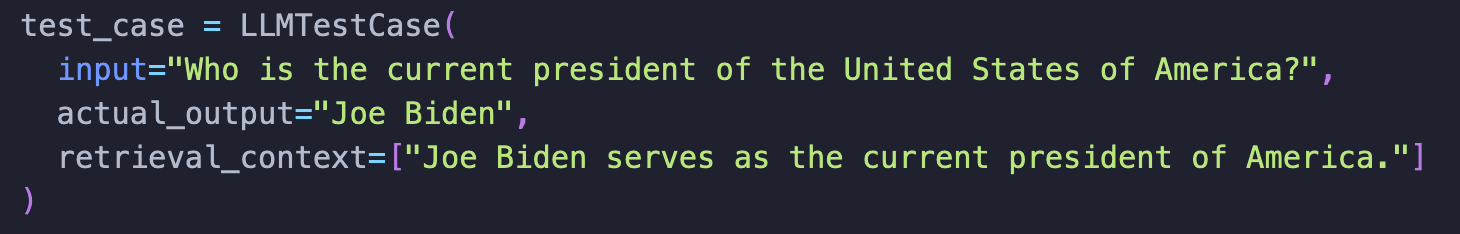)

In [22]:
from deepeval.test_case import LLMTestCase
from src.evaluation.llm_evaluation import AnswerCorrectnessMetric

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/pydantic/_internal/_config.py:284: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)
/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/deepeval/__init__.py:42: UserWarning: You are using deepeval version 0.21.34, however version 0.21.42 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.w

##### 1. Instantiate a metric by passing in the model name (string)

In [23]:
#metric takes in an evaluation LLM of our choice as a string
ac_metric = AnswerCorrectnessMetric('gpt-4-0125-preview')

##### 2. Create a Test Case from the previous query results

In [24]:
#build a Test Case using previous vars
test_case = LLMTestCase(input=query, actual_output=answer, retrieval_context=context)

##### 3. Execute the AnswerCorrectness evaluation by calling the `measure` function
<div class="alert alert-danger"><h5>WARNING - Executing the `measure` function will trigger a call to the LLM that you passed into the `AnswerCorrectnessMetric`.  In this case it's only a single LLM call, so the cost will be minimal, but other metrics in the deepeval library make multiple LLM calls under the hood...</h5></div>

In [25]:
#should see a message from DeepEval
ac_metric.measure(test_case)

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbdad6c6a0>


##### 4. View the `metric` object, pay particular attention to:
- `evaluation_cost` - Cost of running the evaluation test
- `reason` - Reasoning behind the score provided by the evaluation LLM
- `score` - The score result from the evaluation test (as determined by the evaluation LLM)

In [26]:
ac_metric.__dict__

{'model': <deepeval.models.gpt_model.GPTModel at 0x7fbc07eab7c0>,
 'name': 'AnswerCorrectness',
 'evaluation_params': [<LLMTestCaseParams.INPUT: 'input'>,
  <LLMTestCaseParams.ACTUAL_OUTPUT: 'actual_output'>,
  <LLMTestCaseParams.RETRIEVAL_CONTEXT: 'retrieval_context'>],
 'criteria': None,
 'using_native_model': True,
 'evaluation_model': 'gpt-4-0125-preview',
 'evaluation_steps': ['Compare the actual output with the retrieval context to verify factual accuracy.',
  'Assess if the actual output effectively addresses the specific information requirement stated in the input.',
  'Determine the comprehensiveness of the actual output in addressing all key aspects mentioned in the input.',
  'If there is not enough information in the retrieval context to correctly answer the input, and the actual output indicates that the input cannot be answered with the provided context, then return a score of 10.'],
 '_threshold': 0.5,
 'strict_mode': False,
 'async_mode': True,
 'evaluation_cost': 0.019

##### 5. A better way to view the metric data, to include the contextual data associated with the test case is to use the `load_eval_response` function
- Puts the most important information on the top
- Includes the `input`, `actual_output`, and `retrieval_context` data for reference

In [27]:
from src.evaluation.llm_evaluation import load_eval_response

eval_response = load_eval_response(ac_metric, test_case, return_context_data=True).to_dict()
print(eval_response)

{
    'score': 0.8648276393083785,
    'reason': 'The actual output closely aligns with the retrieval context, accurately addressing the importance of
strength training to fight age-related muscle loss, as discussed by Dr. Andy Galpin. It effectively covers the key 
aspect of combating neuromuscular aging through strength training, reflecting the information provided in the 
context. However, it slightly lacks in mentioning the variety of benefits beyond muscle function preservation, such
as cognitive function and immune health benefits, which were highlighted in the retrieval context.',
    'metric': 'AnswerCorrectnessMetric',
    'cost': 0.019960000000000002,
    'eval_model': 'gpt-4-0125-preview',
    'eval_steps': [
        'Compare the actual output with the retrieval context to verify factual accuracy.',
        'Assess if the actual output effectively addresses the specific information requirement stated in the 
input.',
        'Determine the comprehensiveness of the actual output in addressing all key aspects mentioned in the 
input.',
        'If there is not enough information in the retrieval context to correctly answer the input, and the actual 
output indicates that the input cannot be answered with the provided context, then return a score of 10.'
    ],
    'verdicts': None,
    'input': 'How to fight age-related muscle loss',
    'actual_output': 'To fight age-related muscle loss, it is crucial to engage in strength training. Strength 
training helps combat neuromuscular aging by preserving muscle function and power. As we age, we lose muscle mass 
and strength, but strength training can help offset this decline. By challenging the muscles to produce more force 
through strength training, individuals can maintain and even build strength, thus combating age-related muscle 
loss.',
    'retrieval_context': [
        "\nShow Summary: In the Huberman Lab guest series episode with Dr. Andy Galpin, they discuss the science 
and methods to increase strength, hypertrophy (muscle growth), and endurance. Dr. Galpin highlights the importance 
of strength and hypertrophy training for everyone, not just athletes, as it combats neuromuscular aging and 
preserves muscle function. He clarifies that strength training is essential for maintaining muscle power and 
strength, which is crucial for everyday movements and preventing falls as we age. The conversation also touches on 
the benefits of strength and hypertrophy training for cognitive function, immune health, and overall longevity. Dr.
Galpin dispels misconceptions about strength training, emphasizing that it can be started at any age and is not 
solely for building muscle mass, but also for maintaining functional abilities. He also discusses the neuromuscular
adaptations that occur with strength training, such as improved nerve firing, muscle contractility, and changes in 
muscle fiber type.\nShow Guest: Dr. Andy Galpin\nTranscript: In general, human movement is a function of, number 
one, some sort of neuromuscular activation. So nerves have to turn on. The second part is muscles have to contract.
And the third part is those muscles have to move a bone. All right. If you want to be alive and you want to live by
yourself, you have to be able to engage in human movement. If you have any dysfunction in the neuromuscular system 
there, then you're not going to be able to do that. And again, as I mentioned, the only way to preserve that or 
fight that loss of aging is to strength train. So people will tend to hear numbers like you lose about 1% of muscle
size per year after age about 40. And that's true. However, what they don't realize is you lose about 2% to 4% of 
your strength per year. So the loss of strength is almost double that, the loss of muscle mass with aging. Muscle 
power is more like 8% to 10% per year.\n------------------------\n",
        "\nShow Summary: In the Huberman Lab Podcast #65, Dr. Andrew Huberman hosts Dr. Andy Galpin, a professor of
kinesiology a

### Scoring Model Responses with inadequate context 
If we take a look at the evaluations steps from our metric, you'll note that the last step instructs the evaluation LLM to score a 10 (which turns into a 1.0 when output) if the reader model states that it "cannot answer the question given the context" if the context does not provide enough information to answer the user question.  We don't want to assign a score of 0 here, becuase the reader model is doing the right thing by stating it cannot answer the question, as opposed to making something up.  Next week we'll address how to score inadequate answers when we know the answer is in the corpus, but is not present in the context by adding "golden answers" to the mix.  For now, let's see if the evaluation model correctly assigns a score of 1.0 to some queries where I know the answers aren't present. 

In [28]:
fake_queries = [ "What are Musk's exact plans for taking over Mars",
                 "What is Andrew Huberman's middle name",
                 "How long do you think Peter Attia will live"
               ]

In [29]:
#this will make three calls to your designated reader model
packets = [pipe(q) for q in fake_queries]

##### RUNNING THE TEST BELOW TOOK ME 10 SECONDS AND COST 5 or 6 CENTS

In [30]:
%%time

# iterate over the packets and view the responses
responses = []
for packet in packets:

    #unpack each packet
    query, context, answer = [v for v in packet.values()]

    #create a test case
    test_case = LLMTestCase(query, answer, retrieval_context=context)

    #execute an AnswerCorrectness measure
    ac_metric.measure(test_case)

    #aggregate results
    responses.append(load_eval_response(ac_metric, test_case, return_context_data=True))

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbe9655d80>


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbe96a9fc0>


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbe96ab640>


CPU times: user 663 ms, sys: 66.2 ms, total: 729 ms
Wall time: 8.09 s


In [31]:
cost = sum([r.cost for r in responses])
scores = [r.score for r in responses]
reasons = [r.reason for r in responses]

#### Assuming your evaluation LLM is doing it's job correctly you should see scores of 1 (or close to 1) for each response

In [32]:
print(cost, scores, reasons)

0.05154
[0.9999999999999998, 1.0, 1.0000000000000002]
[
    "Given the retrieval context provided, none of the details pertain to Musk's plans for Mars, making it 
impossible to answer the question based on the given information.",
    'The actual output correctly indicates that the input cannot be answered with the provided context, aligning 
with the evaluation criteria that if there is not enough information to answer the input, a score of 10 should be 
given.',
    'The output correctly indicates that the question cannot be answered with the provided context, adhering to the
evaluation criteria.'
]

# Assignment 2.4 - LLM Response Evaluation Baseline

On April 29th, 2024 Cohere released a paper title [Replacing Judges with Juries: Evaluating LLM Generations with a Panel of Diverse Models](https://arxiv.org/pdf/2404.18796), with the following conclusion: *"we find that performing an evaluation composed of a larger number of smaller models outperforms a single large judge, exhibits less intra-model bias due to its composition of dis-joint model families, and does so while being over seven times less expensive..."* As a result of this exciting finding I decided to implement a last-minute change to this notebook by including a version of a multi-model evaluation instead of a single-model option.  Please review your options for this Assignment below. 

#### Option 1: Single high-performance model i.e. GPT-4
#### Option 2: Panel of judges i.e. mix of gpt-3.5-turbo, Claude Haiku, and Cohere command-r
---
#### Breakdown of Options (assumes using 20 test cases):  

**Option 1: Single Model - GPT-4** 

- **Logistics**: Only need a single api key
- **Evaluation Time**: 3.5 minutes
- **Cost**: 40 cents ($0.02 per case x 20 test cases)
- **My Eval Score**: 0.905

**Option 2: Multiple Models**

- **Logistics**: Requires multiple API keys (I used OpenAI, Anthropic, and Cohere). Also requires a Custom model Class to work with DeepEval.  Implementations are already available for use with Cohere, Anthropic, and Azure OpenAI, and can be **found at the end of this notebook**.  If you want to use a different model, examples are available in the [repo codebase](https://github.com/americanthinker/vectorsearch-applications/blob/main/src/evaluation/llm_evaluation.py) in the `llm_evalation.py` file (lines 20-159) or in the `deepeval` [documentation](https://docs.confident-ai.com/docs/metrics-introduction#mistral-7b-example). 
- **Evaluation Time**: 1 minute
- **Cost**: 6 cents ($0.001 per case x 20 test cases x 3 models)
- **My Eval Score**: 0.915

##### My recommendation is to go with Option 2 because it's faster, cheaper, and just as accurate as a single high-performing model. Option 2 is based on the research performed by the company Cohere [in this paper](https://arxiv.org/pdf/2404.18796). 
***
<div class="alert alert-danger"><h5>WARNING - I ran this evaluation using gpt-4-0125-preview and the average cost of each test case call was $0.02 for a total of 40 cents for the entire evaluation.  Feel free to use less data or use a less expensive evaluation model, if necessary to cut down on cost.</h5></div>

#### *Get a baseline evaluation for LLM responses, using a pre-defined dataset of test cases*
1. Fill out code sections marked with **None**. Previously generated test cases can be found at this path: `vectorsearch-applications/data/golden_datasets/llm_eval_testcases_initial.json`
2. Format `test_case_data` as LLMTestCases (this step is completed for you).
3. The deepeval `evaluate` function takes two required parameters:
   - a list of test_cases (for bulk evaluation)
   - a list of metrics (in this case it will be a list of length one with a single `AnswerCorrectness` metric
   - Be sure to pass in the `evaluation_llm` string as an arg to your metric
4. Submit your scores and the final evaluation score as your Week 2: Final Project

## Option 1: Single Powerfule Model evaluation
---

In [33]:
from deepeval import evaluate
from src.evaluation.llm_evaluation import EvalResponse
from deepeval.test_case import LLMTestCase
from src.evaluation.llm_evaluation import AnswerCorrectnessMetric, load_eval_response
from notebook5_helpers import generate_project2_submission_file

def baseline_evaluation(test_cases: list[LLMTestCase],
                        evaluation_llm: str,
                        raw_response: bool=False
                        ) -> list[EvalResponse]:
    '''
    Execute bulk evaluation of test cases with a defined metric.
    '''
    #################
    ##  START CODE ##
    #################

    ac_metric = AnswerCorrectnessMetric(evaluation_llm)
    responses = evaluate(test_cases,[ac_metric], print_results=False)

    #################
    ##  END CODE   ##
    #################
    if raw_response:
        return responses
    eval_responses = [load_eval_response(r.metrics, r) for r in responses]

    scores = [r.score for r in eval_responses]
    eval_score = round(sum(scores)/len(scores),3)
    cost = [r.cost for r in eval_responses if r.cost]
    cost = sum(cost) if any(cost) else 'N/A'
    if cost == 'N/A':
        print(f'Total cost for this evaluation is not available. Non-OpenAI model cost information is not supported at this time.')
    else: print(f'Total cost for this evaluation run: ${round(cost, 2)}')
    print(f'Evaluation Score: {eval_score}')

    return {'responses': eval_responses, 'scores': scores, 'evaluation_score': eval_score, 'cost': cost}

### Execute `baseline_evaluation`

In [41]:

#################
##  START CODE ##
#################

# 20 test cases have already been previously generated
test_case_data = FileIO.load_json('../data/golden_datasets/llm_eval_testcases_initial.json')
#have to be converted from dict to LLMTestCase format to work in evaluate function
baseline_test_cases = [LLMTestCase(**data) for data in test_case_data]

#execute evaluation
responses = baseline_evaluation(baseline_test_cases, 'gpt-4-0125-preview')

#################
##  END CODE   ##
#################

generate_project2_submission_file(responses)

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc1117a00>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc10510c0>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=94 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=98 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=99 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=105 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=119 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=118 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc1117160>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc10505e0>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc0f36500>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc1109d80>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc1122ce0>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc1117400>


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc1051300>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc1121780>


Output()

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc1116a40>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbe96ed1e0>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc0f379a0>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=122 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=99 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=105 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=118 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=125 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=128 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=135 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=138 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=131 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=134 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=141 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc0f04760>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc110a740>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc1121d20>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc1117d00>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc1120160>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc1116f20>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbc1120280>


/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Total cost for this evaluation run: $0.41

Evaluation Score: 0.874

## Option 2: Panel of Judges Evaluation
---

In [18]:
from src.evaluation.llm_evaluation import EvalResponse
from src.evaluation.llm_evaluation import PollingEvaluation
from deepeval.models import DeepEvalBaseLLM
from deepeval.test_case import LLMTestCase
from notebook5_helpers import generate_project2_submission_file

#################
##  START CODE ##
#################

# 20 test cases have already been previously generated
test_case_data = FileIO.load_json(None)

#have to be converted from dict to LLMTestCase format to work in evaluate function
baseline_test_cases = [LLMTestCase(**data) for data in test_case_data]
evaluation_llms = [None, None, None]
evaluator = PollingEvaluation()
responses = evaluator.polling_evaluation(test_cases=None, models=None)

#################
##  END CODE   ##
#################
generate_project2_submission_file(responses, outpath='./project2_polling.txt')

### Run this cell after executing the polling_evaluation method

In [19]:
mean_scores = responses['mean_scores']
evaluation_score = responses['evaluation_score']
print(f'Mean Scores across all models: {mean_scores}')
print(f'Evaluation Score: {evaluation_score}')
print(responses.keys())

# *** Optional: Using Custom Evaluation LLMs ***

`deepeval` provides a way to use evaluation LLMs other than OpenAI models.  Just know that if you do so, cost information is not supported with other models at this time.  CustomClass wrappers have already been written for this course that support Anthropic, AzureOpenAI, and Cohere models.  To use them see code examples below. Loading these models assumes you have the following environment variables set:  

**Anthropic**
- `ANTHROPIC_API_KEY`
  
**Azure**
- `AZURE_OPENAI_API_KEY`
- `AZURE_OPENAI_ENDPOINT`
- `AZURE_OPENAI_API_VERSION`
  
**Cohere**
- `COHERE_API_KEY`


In [16]:
from src.evaluation.llm_evaluation import CustomAnthropic, CustomAzureOpenAI, CustomCohere
from src.evaluation.llm_evaluation import AnswerCorrectnessMetric
haiku = CustomAnthropic('claude-3-haiku-20240307')
azure = CustomAzureOpenAI('gpt-4')
cohere = CustomCohere('command-r')

#then pass in the custom model as an arg to AnswerCorrectnessMetric to use with evaluations
ac_metric = AnswerCorrectnessMetric(model=cohere)

# *** Optional: Generating your own Test Cases ***

If you'd like to quickly generate your own Test Cases, I have included a function which will asynchronously make LLM calls to speed up the process. If you plan on using this function, make sure that your Rate Limit will support the amount of Test Cases you want to generate, or submit your calls in fewer batches to avoid the 429 error. 

In [47]:
from src.evaluation.llm_evaluation import TestCaseGenerator

### Set Components

In [55]:
model_path = "Alibaba-NLP/gte-large-en-v1.5"

collection_name = 'Huberman_gte_large_1024'
api_key = os.environ['WEAVIATE_API_KEY']
url = os.environ['WEAVIATE_ENDPOINT']
turbo = 'gpt-3.5-turbo-0125'
llm = LLM(turbo)
retriever = WeaviateWCS(endpoint=url, api_key=api_key, model_name_or_path=model_path, trust_remote_code=True)
reranker = ReRanker(model_name='cross-encoder/ms-marco-MiniLM-L-12-v2')

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=144 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=118 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=122 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=125 read=idle write=<idle, bufsize=0>>
  _war

In [56]:
#instantiate the TestCaseGenerator
tcg = TestCaseGenerator(llm, retriever, reranker)

### Get Queries
The data needed to generate test cases is a list of queries.  You can either generate these manually or use an LLM to generate them for you.  In this example, I am grabbing the queries from one of the available golden datasets.  

In [50]:
data_path = '../data/golden_datasets/golden_256.json'
data = FileIO.load_json(data_path)
queries = list(data['queries'].values())
print(queries[:5], len(queries))

[
    'How can one deliberately increase adrenaline while staying calm mentally, and what utility does this have in 
dealing with unwanted events?',
    'What behavioral approach can be used to deliberately turn off the communication between sensory neurons and 
motor neurons for pain relief?',
    "How has Tim Ferriss's approach changed since writing The 4-Hour Body, in terms of optimizing and de-optimizing
certain areas for well-being?",
    'How can visualizing failure be an effective strategy to motivate oneself when feeling unmotivated towards a 
goal?',
    'How do people find a comfortable level when taking betaine HCL pepsin tablets or capsules?'
]
100

In [51]:
len(queries)

100

In [52]:
# decide how many test cases you want to create
query_20 = queries[:20]

#### Create Test Cases
Executing the `acreate_test_cases` function performs the following operations under the hood:
- Retrieves context for the queries submitted.
- Reranks them using the ReRanker
- Passes that context to the LLM to generate an answer to the query (this step is performed asynchronously)
- Loads all information, input, actual_output, and retrieval_context into a LLMTestCase bundle and returns a list of LLMTestCases

In [57]:
test_cases = await tcg.acreate_test_cases(query_20, collection_name)

QUERIES:   0%|          | 0/20 [00:00<?, ?it/s]

LLM CALLS: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]


In [58]:
test_cases[0]

LLMTestCase(input='How can one deliberately increase adrenaline while staying calm mentally, and what utility does this have in dealing with unwanted events?', actual_output='To deliberately increase adrenaline while staying calm mentally, one can engage in practices such as cold exposure, intense exercise, or specific breathing techniques. This deliberate induction of adrenaline while maintaining mental calmness can help in preparing the body to push back against potential infections from bacteria or viruses during unwanted events or stressful situations.', expected_output=None, context=None, retrieval_context=['\nShow Summary: In the episode "Using Cortisol & Adrenaline to Boost Our Energy & Immune System Function," Andrew Huberman discusses the importance of cortisol and adrenaline in regulating energy levels and immune system function. He emphasizes the benefits of optimizing cortisol release through morning sunlight exposure and leveraging short-term stress to boost immunity and l

In [59]:
responses = baseline_evaluation(test_cases, 'gpt-4-0125-preview')

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...


/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=166 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=174 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

KeyboardInterrupt: 

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbdb40dcc0>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbb7206fa60>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbb7206f100>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbb6097be80>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbb6097b940>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbb5f131780>


Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=125 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=134 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=144 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=157 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=163 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=167 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=170 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=173 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=178 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 
unclosed transport <_SelectorSocketTransport fd=186 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ResourceWarning: Enable tracemalloc to get the object allocation traceback

Output()

/Users/neerajprad/miniconda3/envs/vs-uplimit/lib/python3.10/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbb609784c0>


In [61]:
responses

{'responses': [EvalResponse(score=0.8688690295253961, reason="The actual output closely aligns with the retrieval context, accurately reflecting the discussed neuroscience and psychology principles regarding goal motivation and the role of visualizing failure. It succinctly synthesizes key insights from the provided context, effectively addressing the specific information requirement by linking the fear of failure to motivation through emotional processing and the amygdala's role. However, it slightly lacks in detailing the comprehensive neural circuitry involved in goal-oriented behavior, which was mentioned in the retrieval context.", metric='AnswerCorrectnessMetric', cost=0.02113, eval_model='gpt-4-0125-preview', eval_steps=['Compare the actual output with the retrieval context to verify factual accuracy.', 'Assess if the actual output effectively addresses the specific information requirement stated in the input.', 'Determine the comprehensiveness of the actual output in addressing